Note: This notebook needs to be run with a GPU

In [1]:
import sys
sys.path.append("/home/gridsan/vyuan/.local/lib/python3.9/site-packages")
sys.path.append("../src")

In [2]:
import torch
import os
import random
import json
from pathlib import Path

from plots import plots
from utils import data_utils, utils
from models import cbm

In [3]:
root = Path.cwd().parent.parent
os.chdir(root)

In [4]:
# change this to the correct model dir, everything else should be taken care of
load_dir = "saved_models/doctor_nurse_full_cbm_2023_06_11_22_55"
path_model_dir = root / load_dir
device = "cuda" if torch.cuda.is_available() else 'cpu'


with open(root / os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["dataset"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device, root)
model = cbm.load_cbm(path_model_dir, device)

In [5]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe, preprocess=target_preprocess)
val_pil_data = data_utils.get_data(val_d_probe)

In [6]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, "concepts.txt"), "r") as f:
    concepts = f.read().split("\n")

## Measure accuracy

In [7]:
accuracy = utils.get_accuracy_cbm(model, val_data_t, device)
print("Accuracy: {:.2f}%".format(accuracy*100))

  0%|          | 0/3 [00:00<?, ?it/s]/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  0%|          | 0/3 [00:06<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 172, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 172, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 180, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [16]:
to_show = random.choices([i for i in range(len(classes))], k=2)

for i in to_show:
    print("Output class:{} - {}".format(i, classes[i]))
    print("Incoming weights:")
    for j in range(len(concepts)):
        if torch.abs(model.final.weight[i,j])>0.05:
            print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))

Output class:0 - doctor
Incoming weights:
a bed [-0.1344] doctor
a desk [0.0512] doctor
a doctor's office [0.1844] doctor
a hospital [-0.1236] doctor
a medical chart [0.1825] doctor
a medication [0.1671] doctor
a nurse's station [-0.1160] doctor
a patient [0.0670] doctor
a syringe [-0.0824] doctor
a thermometer [-0.1108] doctor
a tongue depressor [-0.1039] doctor
a white coat [0.4438] doctor
carrying a stethoscope [0.1391] doctor
expert [0.0820] doctor
health care worker [-0.0538] doctor
person [0.0522] doctor
professional [-0.0760] doctor
wearing a white uniform [-0.1967] doctor
wearing scrubs [-0.2591] doctor
Output class:1 - nurse
Incoming weights:
a bed [0.1344] nurse
a desk [-0.0512] nurse
a doctor's office [-0.1844] nurse
a hospital [0.1236] nurse
a medical chart [-0.1825] nurse
a medication [-0.1671] nurse
a nurse's station [0.1160] nurse
a patient [-0.0670] nurse
a syringe [0.0824] nurse
a thermometer [0.1108] nurse
a tongue depressor [0.1039] nurse
a white coat [-0.4438] nurse

In [12]:
to_show = random.choices([i for i in range(len(classes))], k=2)

top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for i in to_show:
    print("Class {} - {}".format(i, classes[i]))
    out = "Highest weights: "
    for j in range(top_weights.shape[1]):
        idx = int(top_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
    print(out)
    out = "Lowest weights: "
    for j in range(bottom_weights.shape[1]):
        idx = int(bottom_weight_ids[i, j].cpu())
        out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
    print(out + "\n")

Class 152 - Philadelphia Vireo
Highest weights: a small, green body:0.431, a brown and white color scheme:0.402, blue wings with white bars:0.372, a red face:0.369, a small, greenish-gray bird:0.357, 
Lowest weights: a black back:-0.415, long tail with white stripes:-0.408, a black and white barred tail:-0.350, a medium-sized duck:-0.312, a rosy breast:-0.286, 

Class 97 - Scott Oriole
Highest weights: black wings with orange bars:0.697, black and orange plumage:0.496, yellow wings with black bars:0.414, dark gray or black upperparts:0.363, a black and white barred tail:0.363, 
Lowest weights: a long, thin neck:-0.449, a long, orange-red beak:-0.437, a small, black bird:-0.332, silky, brown feathers:-0.284, a white head and neck:-0.244, 



In [13]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
weight_contribs = torch.sum(torch.abs(model.final.weight), dim=0)
print("Num concepts with outgoing weights:{}/{}".format(torch.sum(weight_contribs>1e-5), len(weight_contribs)))

Num concepts with outgoing weights:208/208


## Explain model reasoning for random inputs

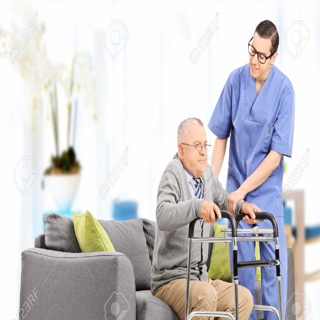

TypeError: conv2d() received an invalid combination of arguments - got (Image, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Image!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!Image!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


In [8]:
to_display = random.sample([i for i in range(len(val_pil_data))], k=4)

with torch.no_grad():
    for i in to_display:
        image, label = val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        display(image.resize([320,320]))
        
        outputs, concept_act = model(x)
        
        top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
        conf = torch.nn.functional.softmax(outputs[0], dim=0)
        print("Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                      classes[top_classes[1]], top_logit_vals[1]))
        
        for k in range(1):
            contributions = concept_act[0]*model.final.weight[top_classes[k], :]
            feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
            values = contributions.cpu().numpy()
            max_display = min(int(sum(abs(values)>0.005))+1, 8)
            title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                             conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
            plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16)

In [11]:
x.unsqueeze(0)

AttributeError: unsqueeze

In [9]:
model

CBM_model(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj_layer): Linear(in_features=256, out_features=33, bias=False)
  (final): L